In [1]:
from datetime import datetime

from pathlib import Path

import numpy as np
from scipy.stats import lognorm
import pandas as pd

from astropy import stats
import astropy.units as u
from astropy.io import fits
from astropy.visualization import hist

from matplotlib import style
style.use('ggplot')
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2
#%matplotlib widget

In [2]:
YEAR = 2022
rootdir = Path("./data")
# use find to make this csv list
with open(rootdir / f"reanalyze_csvs_{YEAR}.txt") as f:
    csvs = f.readlines()

# loop through the csv files and read them with pandas
frames = []
for csv in csvs:
    frames.append(pd.read_csv(rootdir / csv.rstrip()))

# now concat each frame into one big frame containing all of the data
data = pd.concat(frames)

In [3]:
g = data.groupby('wfs')
g.wfs.describe()

,count,unique,top,freq
wfs,,,,
binospec,39988,1,binospec,39988
f5,2400,1,f5,2400
mmirs,2261,1,mmirs,2261
newf9,791,1,newf9,791


In [4]:
# re-calculate the seeing using updated spot FWHM for binospec. filter out any NaN values...
#fixed_list = []
#for wfskey, group in g:
#    wfs = wfs_systems[wfskey]
#    group = g.get_group(wfskey)
#    #group.apply(seeing, axis=1, args=(wfs,))
#    group['fixed_raw_seeing'], group['fixed_seeing'] = seeing(group, wfs)
#    fixed_list.append(group)
#fixed = pd.concat(fixed_list)
#fixed.rename(index=str, columns={"seeing": "orig_seeing", "raw seeing": "orig_raw_seeing"}, inplace=True)
#fixed.rename(index=str, columns={"fixed_seeing": "seeing", "fixed_raw_seeing": "raw seeing"}, inplace=True)
fixed = data[np.isfinite(data['seeing'])]
fixed = fixed[fixed['fwhm'] > 0.]
fixed = fixed[fixed['seeing'] > 0.]
fixed = fixed[fixed['seeing'] < 4.]
#fixed = fixed[fixed['time'] < "2020-12-31"]

In [5]:
fixed.sort_values(by='time')

,time,wfs,file,exptime,airmass,az,el,osst,outt,chamt,...,xcen,ycen,seeing,raw_seeing,vlt_seeing,raw_vlt_seeing,ellipticity,fwhm,wavefront_rms,residual_rms
0,2022-01-05T01:44:24,f5,manual_wfs_0000.fits,30.0,1.6382,207.718372,37.620416,10.00,5.1,6.761,...,245.994567,265.996913,1.594422,2.143994,1.328274,1.786108,0.055321,11.515436,1268.930035,2869.310986
1,2022-01-05T01:46:20.640000,f5,manual_wfs_0001.fits,30.0,1.6454,208.256616,37.427962,9.95,5.1,6.666,...,245.998291,264.998336,1.411806,1.903435,1.185521,1.598352,0.063341,10.487151,974.233840,2968.544260
2,2022-01-05T01:47:40.128000,f5,manual_wfs_0002.fits,30.0,1.6504,208.618865,37.295837,9.90,5.1,6.699,...,243.991769,265.997415,1.435518,1.938930,1.216366,1.642925,0.121067,10.639803,587.876509,3524.238805
3,2022-01-05T01:48:49.248000,f5,manual_wfs_0003.fits,30.0,1.6548,208.936857,37.178066,9.85,5.1,6.555,...,244.999006,270.004282,1.428533,1.932581,1.207646,1.633755,0.085979,10.612521,796.711275,2866.458551
4,2022-01-05T01:50:00.960000,f5,manual_wfs_0004.fits,30.0,1.6595,209.262262,37.055822,9.80,5.0,6.687,...,244.004442,267.006922,1.334851,1.808919,1.124377,1.523696,0.091428,10.079076,1015.392356,3015.942818
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13,2022-12-31T10:47:23.330000,f5,f5wfs_20221231-034755.fits,30.0,1.1233,233.506191,62.903948,2.60,2.3,2.961,...,282.990009,265.998484,1.047555,1.123245,0.952094,1.020886,0.023725,7.047622,164.915694,1463.025934
14,2022-12-31T11:40:26.267000,f5,f5wfs_20221231-044059.fits,30.0,1.2049,244.140141,56.094506,2.00,1.5,1.770,...,283.001383,286.997630,1.395949,1.561134,1.206577,1.349353,0.076221,8.997964,893.068100,1451.495954
15,2022-12-31T11:41:44.155000,f5,f5wfs_20221231-044217.fits,30.0,1.2083,244.480728,55.853225,2.00,1.5,1.737,...,282.994212,283.008699,1.552202,1.738814,1.316152,1.474385,0.025871,9.774868,266.254158,1486.359850
16,2022-12-31T12:31:53.901000,f5,f5wfs_20221231-053226.fits,30.0,1.4589,98.513533,43.270382,2.20,1.7,2.094,...,258.991242,272.007776,1.140575,1.430669,0.983631,1.233808,0.064084,8.422075,1613.472141,1430.818700


In [6]:
# create a date-time index so we can group and analyze the data by timestamps
fixed = fixed.set_index(pd.DatetimeIndex(fixed['time'], name='ut'))

<Figure size 800x500 with 0 Axes>

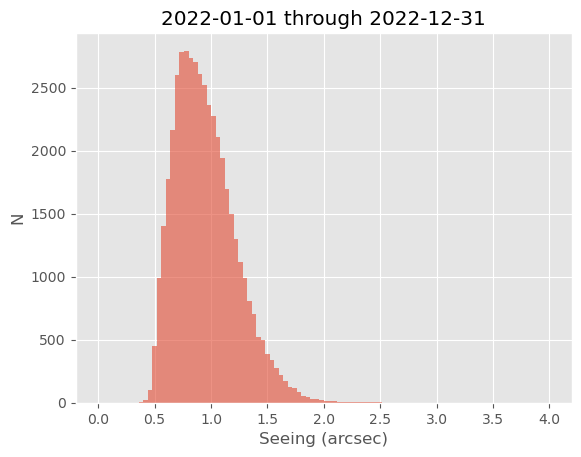

In [7]:
# make raw histogram of the zenith-corrected seeing column
fig = plt.figure(figsize=(8, 5))
fixed.hist(column='vlt_seeing', bins=100, range=(0.0, 4.0), alpha=0.6)
with plt.style.context('ggplot'):
    plt.title(f"{YEAR}-01-01 through {YEAR}-12-31")
    plt.xlabel("Seeing (arcsec)")
    plt.ylabel("N")
plt.show()

In [8]:
# fit a log-normal distribution to the seeing data
sigma, loc, exp_mu = lognorm.fit(fixed['vlt_seeing'])
print(sigma, loc, exp_mu)
x = np.arange(0.0, 4.0, 0.01)
p = lognorm.pdf(x, sigma, loc=loc, scale=exp_mu)
mu = np.log(exp_mu)
mode = np.exp(mu - sigma**2) + loc
median = np.nanmedian(fixed['vlt_seeing'])
fit_median = exp_mu + loc

0.33921516745429886 0.15850728112348494 0.7495255891802418


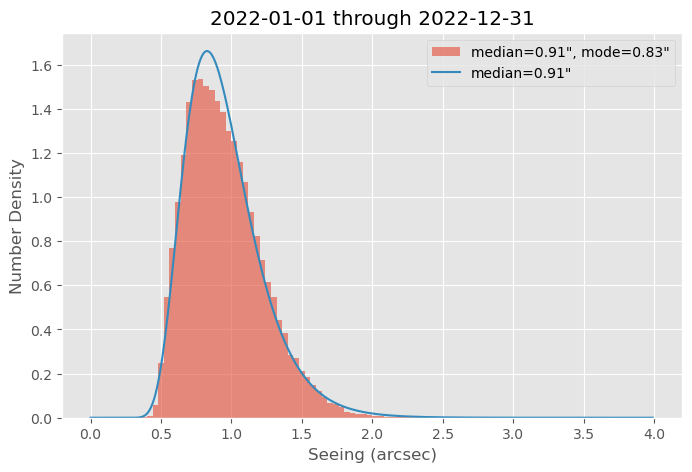

In [9]:
# plot normalized histogram with the fit and the median/mode calculated from the fit.
fig = plt.figure(figsize=(8, 5))
with plt.style.context('ggplot'):
    plt.hist(fixed['vlt_seeing'], density=True, bins=100, range=(0.0, 4.0), label="hist", alpha=0.6)
    logp = plt.plot(x, p, label="logp")
    plt.xlabel("Seeing (arcsec)")
    plt.ylabel("Number Density")
    plt.title(f"{YEAR}-01-01 through {YEAR}-12-31")
    plt.legend(["median=%.2f\", mode=%.2f\"" % (fit_median, mode), "median=%.2f\"" % (
        median
    )])
    plt.savefig(f"{YEAR}_allyear.png")
plt.show()

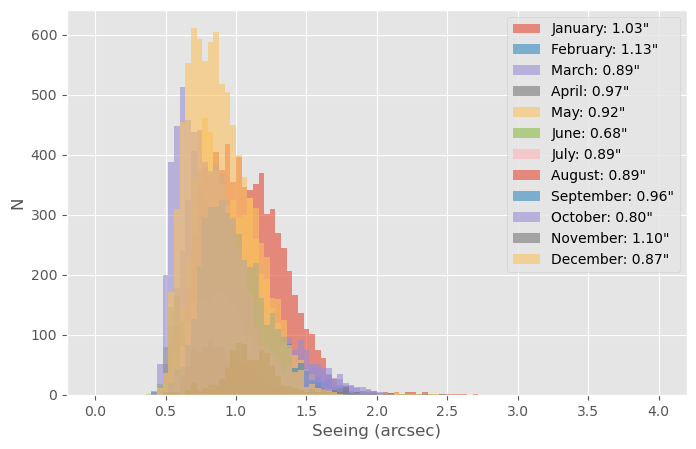

In [10]:
# panda time indexing makes it easy to group by month
fig = plt.figure(figsize=(8, 5))
months = {}
legends = []
months["January"] = fixed.loc[f"{YEAR}-01"]
months["February"] = fixed.loc[f"{YEAR}-02"]
months["March"] = fixed.loc[f"{YEAR}-03"]
months["April"] = fixed.loc[f"{YEAR}-04"]
months["May"] = fixed.loc[f"{YEAR}-05"]
months["June"] = fixed.loc[f"{YEAR}-06"]
months["July"] = fixed.loc[f"{YEAR}-07"]
months["August"] = fixed.loc[f"{YEAR}-08"]
months["September"] = fixed.loc[f"{YEAR}-09"]
months["October"] = fixed.loc[f"{YEAR}-10"]
months["November"] = fixed.loc[f"{YEAR}-11"]
months["December"] = fixed.loc[f"{YEAR}-12"]
for m in months:
    plt.hist(months[m]["vlt_seeing"], bins=100, range=(0.0, 4.0), label=m, alpha=0.6)
    legend = "%s: %.2f\"" % (m, np.median(months[m]["vlt_seeing"]))
    legends.append(legend)
plt.legend(legends)
plt.xlabel("Seeing (arcsec)")
plt.ylabel("N")
#plt.title("Data and median seeing values grouped by month")
plt.savefig(f"{YEAR}_monthly.png")
plt.show()

In [11]:
# now use the between_time() method to split the data into first and second halves of the night.
first_half = fixed.between_time(start_time='00:00', end_time='07:00')
second_half = fixed.between_time(start_time='07:00', end_time='14:00')
#first_half = months['December'].between_time(start_time='00:00', end_time='07:00')
#second_half = months['December'].between_time(start_time='07:00', end_time='14:00')
med_1st = np.median(first_half['vlt_seeing'])
med_2nd = np.median(second_half['vlt_seeing'])

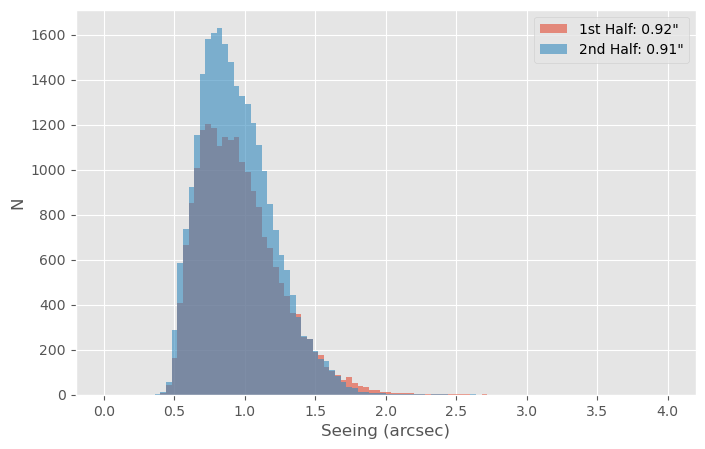

In [12]:
# plot the results and show that the seeing is better later in the night...
fig = plt.figure(figsize=(8, 5))
plt.hist(first_half['vlt_seeing'], bins=100, range=(0.0, 4.0), label="1st", alpha=0.6)
plt.hist(second_half['vlt_seeing'], bins=100, range=(0.0, 4.0), label="2nd", alpha=0.6)
plt.legend(["1st Half: %.2f\"" % med_1st, "2nd Half: %.2f\"" % med_2nd])
plt.xlabel("Seeing (arcsec)")
plt.ylabel("N")
#plt.title("Data and median seeing values grouped by half of the night")
plt.savefig(f"{YEAR}_1st2nd.png")
plt.show()

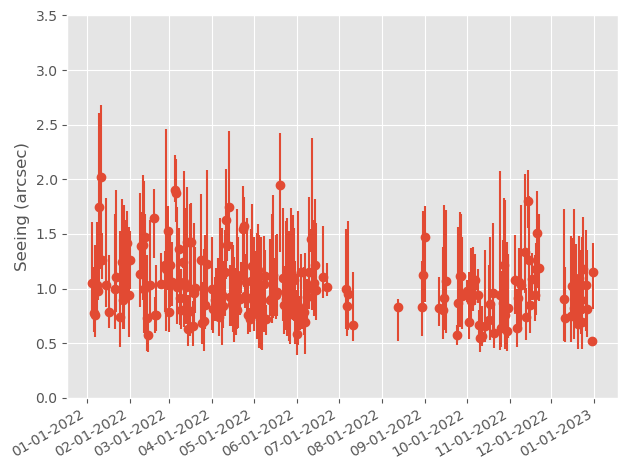

In [13]:
import matplotlib.dates as mdates

# make a new data frame that resamples the WFS data daily into the median, min, and max seeing for each day.
fig, ax = plt.subplots()
daily = pd.DataFrame()
daily['seeing'] = fixed.vlt_seeing.resample('D').median()
daily['max'] = fixed.vlt_seeing.resample('D').max()
daily['min'] = fixed.vlt_seeing.resample('D').min()
lowb = daily['seeing'] - daily['min']
upb = daily['max'] - daily['seeing']
plt.errorbar(daily.index, daily['seeing'], yerr=[lowb, upb], fmt='o')
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter("%m-%d-%Y"))
ax.set_ylim(0.0, 3.5)
fig.autofmt_xdate()
plt.tight_layout()
plt.ylabel("Seeing (arcsec)")
#plt.title("Nightly median seeing")
plt.savefig(f"{YEAR}_nightly.png")
plt.show()

In [14]:
date_list = list(daily.index.strftime('%Y-%m-%d'))
data = [np.array(fixed.loc[date]['vlt_seeing']) for date in date_list]
ellipticity_data = [np.array(fixed.loc[date]['ellipticity']) for date in date_list]
clean_data = {}
clean_ellipticity = {}
for d, arr in zip(date_list, data):
    if len(arr) > 0:
        clean_data[d] = arr
for d, arr in zip(date_list, ellipticity_data):
    if len(arr) > 0:
        clean_ellipticity[d] = arr
date_labels = [datetime.strptime(d, "%Y-%m-%d").date() for d in clean_data.keys()]

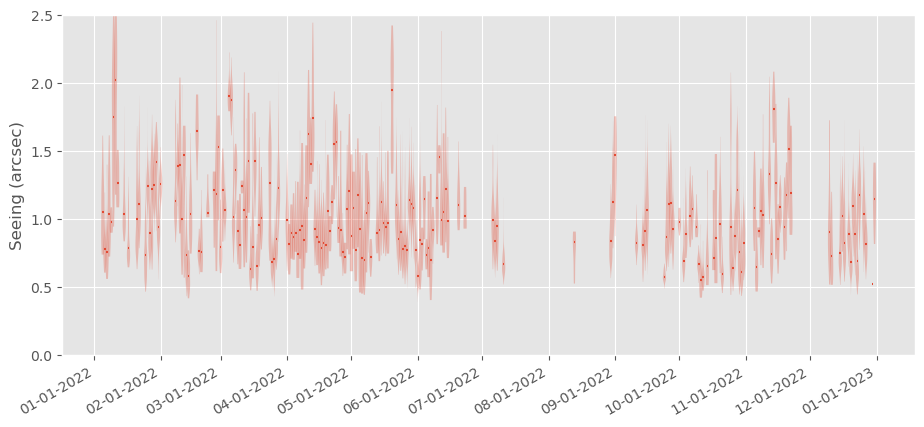

In [15]:
with plt.style.context('ggplot', after_reset=True):
    fig, ax = plt.subplots(figsize=(11,5))
    plt.violinplot(clean_data.values(), mdates.date2num(date_labels), points=50, widths=1.5,
                showextrema=False, showmedians=True, bw_method='silverman')

    ax.xaxis.set_major_locator(mdates.MonthLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%m-%d-%Y"))
    fig.autofmt_xdate()
    ax.set_ylim(0.0, 2.5)
    plt.ylabel("Seeing (arcsec)")
    plt.savefig(f"{YEAR}_violin.png")
    plt.show()

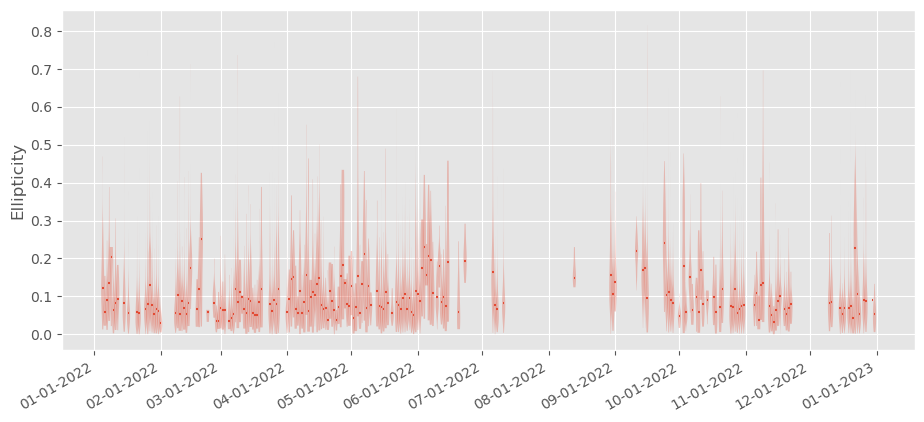

In [16]:
with plt.style.context('ggplot', after_reset=True):
    fig, ax = plt.subplots(figsize=(11,5))
    plt.violinplot(clean_ellipticity.values(), mdates.date2num(date_labels), points=50, widths=1.5,
                showextrema=False, showmedians=True, bw_method='silverman')

    ax.xaxis.set_major_locator(mdates.MonthLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%m-%d-%Y"))
    fig.autofmt_xdate()
    plt.ylabel("Ellipticity")
    plt.savefig(f"{YEAR}_ellip_violin.png")
    plt.show()

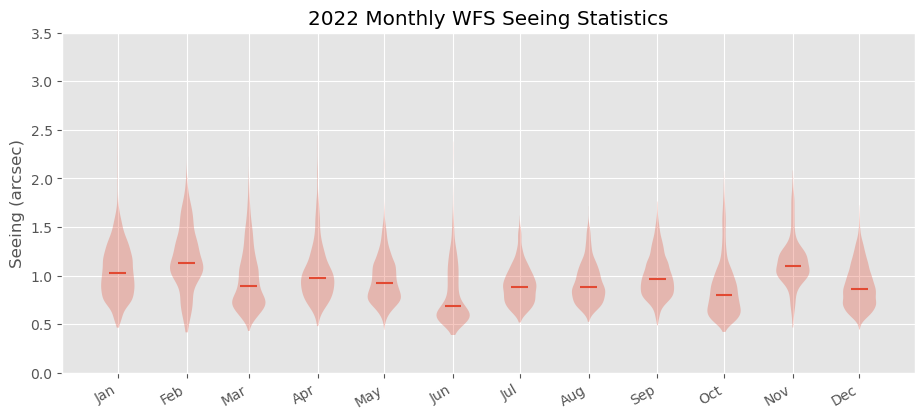

In [17]:
months = sorted(list(set(daily.index.strftime('%Y-%m'))))
mdata = [np.array(fixed.loc[month]['vlt_seeing']) for month in months]
clean_data = {}
for d, arr in zip(months, mdata):
    if len(arr) > 0:
        clean_data[d] = arr
date_labels = [datetime.strptime(d, "%Y-%m").date() for d in clean_data.keys()]

with plt.style.context('ggplot', after_reset=True):
    fig, ax = plt.subplots(figsize=(11,5))
    plt.violinplot(clean_data.values(), mdates.date2num(date_labels), points=100, widths=15,
                showextrema=False, showmedians=True, bw_method='silverman')

    ax.xaxis.set_major_locator(mdates.MonthLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%b"))
    ax.set_ylim(0.0, 3.5)
    fig.autofmt_xdate()
    plt.ylabel("Seeing (arcsec)")
    plt.savefig(f"{YEAR}_violin_monthly.png")
    plt.title(f"{YEAR} Monthly WFS Seeing Statistics")
    plt.show()

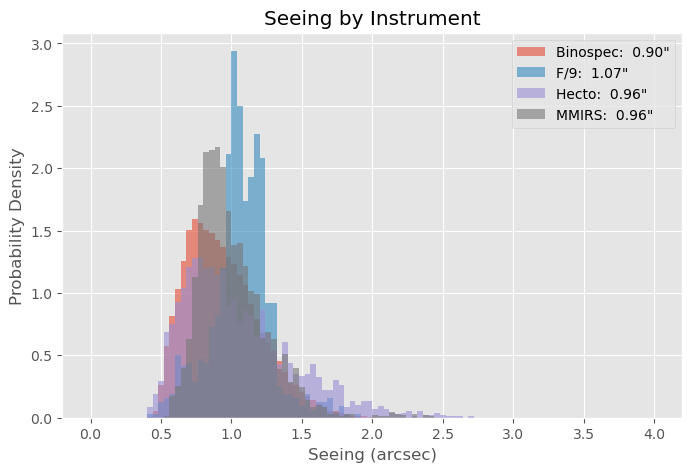

In [18]:
with plt.style.context('ggplot'):
    fig = plt.figure(figsize=(8, 5))
    medb = np.median(fixed['vlt_seeing'][fixed['wfs'] == 'binospec'])
    med9 = np.median(fixed['vlt_seeing'][fixed['wfs'] == 'newf9'])
    medf = np.median(fixed['vlt_seeing'][fixed['wfs'] == 'f5'])
    medm = np.median(fixed['vlt_seeing'][fixed['wfs'] == 'mmirs'])
    plt.hist(fixed['vlt_seeing'][fixed['wfs'] == 'binospec'], density=True, bins=100, range=(0.0, 4.), alpha=0.6, label=f"Binospec: {medb: .2f}\"")
    plt.hist(fixed['vlt_seeing'][fixed['wfs'] == 'newf9'], density=True, bins=100, range=(0.0, 4.), alpha=0.6, label=f"F/9: {med9: .2f}\"")
    plt.hist(fixed['vlt_seeing'][fixed['wfs'] == 'f5'], density=True, bins=100, range=(0.0, 4.), alpha=0.6, label=f"Hecto: {medf: .2f}\"")
    plt.hist(fixed['vlt_seeing'][fixed['wfs'] == 'mmirs'], density=True, bins=100, range=(0.0, 4.), alpha=0.6, label=f"MMIRS: {medm: .2f}\"")
    plt.legend()
    plt.title("Seeing by Instrument")
    plt.xlabel("Seeing (arcsec)")
    plt.ylabel("Probability Density")
plt.savefig(f"per_instrument_{YEAR}.png")
plt.show()

In [19]:
from minicyclop.io import read_seeing_data

In [20]:
cyclop = read_seeing_data(Path.home() / "MMT/minicyclop/data/MiniCyclop/Data/Seeing_Data.txt")

In [21]:
cyclop

,UT,flux,seeing,r0,isot,epoch_ms
ut,,,,,,
2022-06-08 03:32:32,6/8/2022 3:32:32 AM,2733.7,0.84,135.8,2022-06-08T03:32:32.968,1654659152968
2022-06-08 03:33:27,6/8/2022 3:33:27 AM,2755.7,0.84,134.4,2022-06-08T03:33:27.409,1654659207408
2022-06-08 03:34:23,6/8/2022 3:34:23 AM,2801.6,2.38,47.7,2022-06-08T03:34:23.655,1654659263655
2022-06-08 03:35:16,6/8/2022 3:35:16 AM,2853.2,1.01,112.3,2022-06-08T03:35:16.325,1654659316324
2022-06-08 03:36:00,6/8/2022 3:36:00 AM,2739.0,1.03,110.7,2022-06-08T03:36:00.691,1654659360691
...,...,...,...,...,...,...
2025-02-08 06:37:28,2/8/2025 6:37:28 AM,1560.5,0.82,137.7,2025-02-08T06:37:28.007,1738996648007
2025-02-08 06:38:14,2/8/2025 6:38:14 AM,1484.8,0.62,183.9,2025-02-08T06:38:14.421,1738996694421
2025-02-08 06:39:00,2/8/2025 6:39:00 AM,1549.0,0.79,144.3,2025-02-08T06:39:00.913,1738996740912


In [22]:
cyclop_year = cyclop[(cyclop.index >= f"{YEAR}-01-01") & (cyclop.index < f"{YEAR+1}-01-01")]

0.5259441899958446 0.4063111728963935 0.6833913655682596


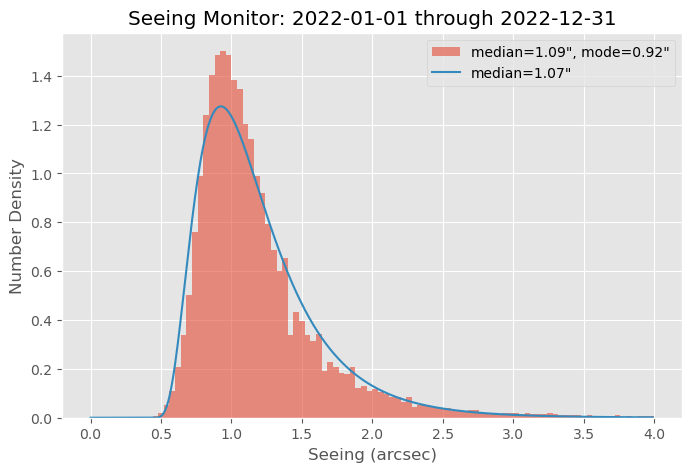

In [39]:
# fit a log-normal distribution to the seeing data
sigma, loc, exp_mu = lognorm.fit(cyclop_year['seeing'])
print(sigma, loc, exp_mu)
x = np.arange(0.0, 4.0, 0.01)
p = lognorm.pdf(x, sigma, loc=loc, scale=exp_mu)
mu = np.log(exp_mu)
mode = np.exp(mu - sigma**2) + loc
median = np.nanmedian(cyclop_year['seeing'])
fit_median = exp_mu + loc

# plot normalized histogram with the fit and the median/mode calculated from the fit.
fig = plt.figure(figsize=(8, 5))
with plt.style.context('ggplot'):
    plt.hist(cyclop_year['seeing'], density=True, bins=100, range=(0.0, 4.0), label="hist", alpha=0.6)
    logp = plt.plot(x, p, label="logp")
    plt.xlabel("Seeing (arcsec)")
    plt.ylabel("Number Density")
    plt.title(f"Seeing Monitor: {YEAR}-01-01 through {YEAR}-12-31")
    plt.legend(["median=%.2f\", mode=%.2f\"" % (fit_median, mode), "median=%.2f\"" % (
        median
    )])
    plt.savefig(f"{YEAR}_cyclop_hist.png")
plt.show()

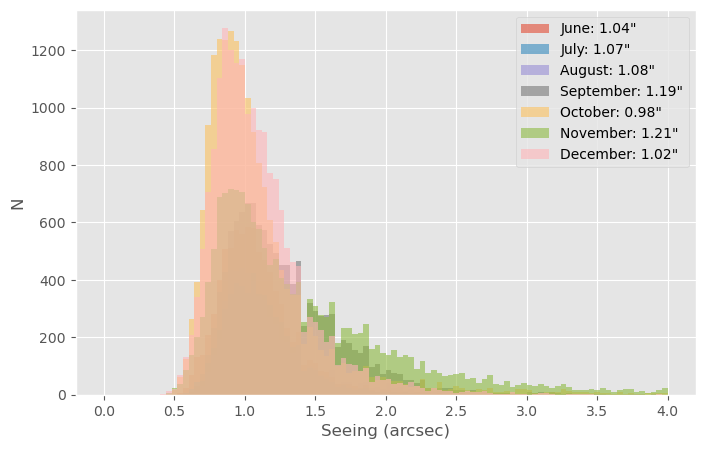

In [25]:
# panda time indexing makes it easy to group by month
fig = plt.figure(figsize=(8, 5))
cyc_months = {}
legends = []
cyc_months["June"] = cyclop_year.loc[f"{YEAR}-06"]
cyc_months["July"] = cyclop_year.loc[f"{YEAR}-07"]
cyc_months["August"] = cyclop_year.loc[f"{YEAR}-08"]
cyc_months["September"] = cyclop_year.loc[f"{YEAR}-09"]
cyc_months["October"] = cyclop_year.loc[f"{YEAR}-10"]
cyc_months["November"] = cyclop_year.loc[f"{YEAR}-11"]
cyc_months["December"] = cyclop_year.loc[f"{YEAR}-12"]
for m in cyc_months.keys():
    plt.hist(cyc_months[m]["seeing"], bins=100, range=(0.0, 4.0), label=m, alpha=0.6)
    legend = "%s: %.2f\"" % (m, np.median(cyc_months[m]["seeing"]))
    legends.append(legend)
plt.legend(legends)
plt.xlabel("Seeing (arcsec)")
plt.ylabel("N")
#plt.title("Data and median seeing values grouped by month")
plt.savefig(f"{YEAR}_cyclop_monthly.png")
plt.show()

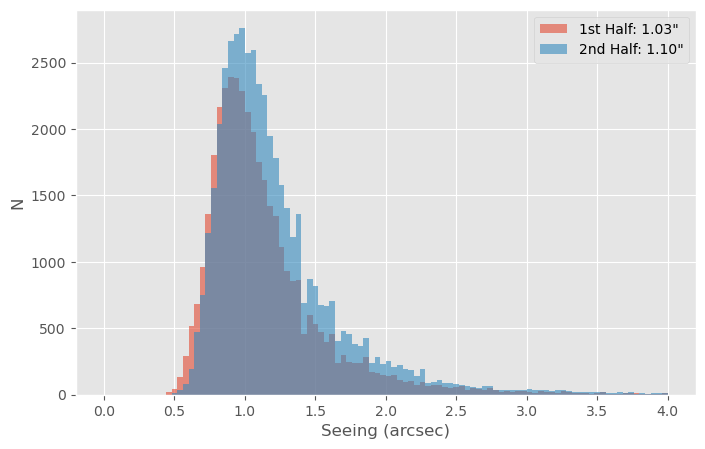

In [26]:
# now use the between_time() method to split the data into first and second halves of the night.
first_half = cyclop_year.between_time(start_time='00:00', end_time='07:00')
second_half = cyclop_year.between_time(start_time='07:00', end_time='14:00')
#first_half = months['December'].between_time(start_time='00:00', end_time='07:00')
#second_half = months['December'].between_time(start_time='07:00', end_time='14:00')
med_1st = np.median(first_half['seeing'])
med_2nd = np.median(second_half['seeing'])

# plot the results and show that the seeing is better later in the night...
fig = plt.figure(figsize=(8, 5))
plt.hist(first_half['seeing'], bins=100, range=(0.0, 4.0), label="1st", alpha=0.6)
plt.hist(second_half['seeing'], bins=100, range=(0.0, 4.0), label="2nd", alpha=0.6)
plt.legend(["1st Half: %.2f\"" % med_1st, "2nd Half: %.2f\"" % med_2nd])
plt.xlabel("Seeing (arcsec)")
plt.ylabel("N")
#plt.title("Data and median seeing values grouped by half of the night")
plt.savefig(f"{YEAR}_cyclop_1st2nd.png")
plt.show()

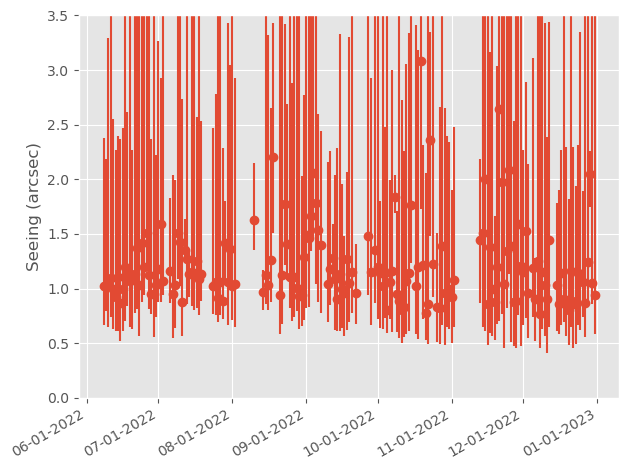

In [27]:
# make a new data frame that resamples the WFS data daily into the median, min, and max seeing for each day.
fig, ax = plt.subplots()
daily = pd.DataFrame()
daily['seeing'] = cyclop_year.seeing.resample('D').median()
daily['max'] = cyclop_year.seeing.resample('D').max()
daily['min'] = cyclop_year.seeing.resample('D').min()
lowb = daily['seeing'] - daily['min']
upb = daily['max'] - daily['seeing']
plt.errorbar(daily.index, daily['seeing'], yerr=[lowb, upb], fmt='o')
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter("%m-%d-%Y"))
ax.set_ylim(0.0, 3.5)
fig.autofmt_xdate()
plt.tight_layout()
plt.ylabel("Seeing (arcsec)")
#plt.title("Nightly median seeing")
plt.savefig(f"{YEAR}_cyclop_plot_monthly.png")
plt.show()

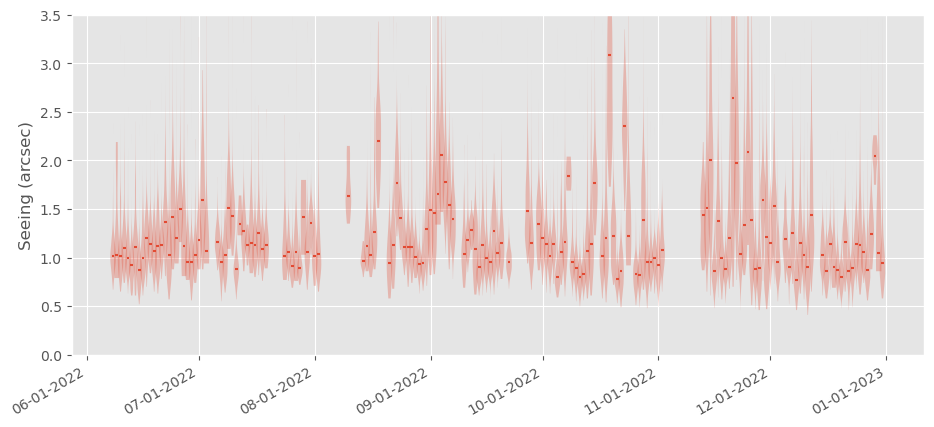

In [28]:
date_list = list(daily.index.strftime('%Y-%m-%d'))
data = [np.array(cyclop_year.loc[date]['seeing']) for date in date_list]
clean_data = {}
for d, arr in zip(date_list, data):
    if len(arr) > 0:
        clean_data[d] = arr
date_labels = [datetime.strptime(d, "%Y-%m-%d").date() for d in clean_data.keys()]

with plt.style.context('ggplot', after_reset=True):
    fig, ax = plt.subplots(figsize=(11,5))
    plt.violinplot(clean_data.values(), mdates.date2num(date_labels), points=50, widths=1.5,
                showextrema=False, showmedians=True, bw_method='silverman')

    ax.xaxis.set_major_locator(mdates.MonthLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%m-%d-%Y"))
    ax.set_ylim(0.0, 3.5)
    fig.autofmt_xdate()
    plt.ylabel("Seeing (arcsec)")
    plt.savefig(f"{YEAR}_cyclop_violin.png")
    plt.show()

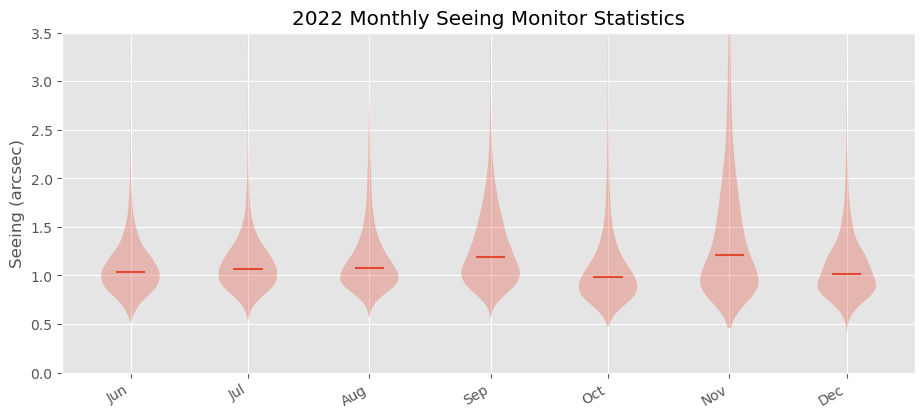

In [29]:
months = sorted(list(set(daily.index.strftime('%Y-%m'))))
mdata = [np.array(cyclop_year.loc[month]['seeing']) for month in months]
clean_data = {}
for d, arr in zip(months, mdata):
    if len(arr) > 0:
        clean_data[d] = arr
date_labels = [datetime.strptime(d, "%Y-%m").date() for d in clean_data.keys()]

with plt.style.context('ggplot', after_reset=True):
    fig, ax = plt.subplots(figsize=(11,5))
    plt.violinplot(clean_data.values(), mdates.date2num(date_labels), points=100, widths=15,
                showextrema=False, showmedians=True, bw_method='silverman')

    ax.xaxis.set_major_locator(mdates.MonthLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%b"))
    ax.set_ylim(0.0, 3.5)
    fig.autofmt_xdate()
    plt.ylabel("Seeing (arcsec)")
    plt.savefig(f"{YEAR}_cyclop_violin_monthly.png")
    plt.title(f"{YEAR} Monthly Seeing Monitor Statistics")
    plt.show()

In [33]:
fixed_overlap = fixed[(fixed.index >= f"{YEAR}-06-08") & (fixed.index < f"{YEAR+1}-01-01")]
f9 = fixed_overlap[fixed['wfs'] == 'newf9']
bino = fixed_overlap[fixed['wfs'] == 'binospec']
hecto = fixed_overlap[fixed['wfs'] == 'f5']
mmirs = fixed_overlap[fixed['wfs'] == 'mmirs']

/var/folders/vx/hkwj3_y50fgbdckq7hcv_p000000gn/T/ipykernel_51658/3534918811.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  f9 = fixed_overlap[fixed['wfs'] == 'newf9']
/var/folders/vx/hkwj3_y50fgbdckq7hcv_p000000gn/T/ipykernel_51658/3534918811.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  bino = fixed_overlap[fixed['wfs'] == 'binospec']
/var/folders/vx/hkwj3_y50fgbdckq7hcv_p000000gn/T/ipykernel_51658/3534918811.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  hecto = fixed_overlap[fixed['wfs'] == 'f5']
/var/folders/vx/hkwj3_y50fgbdckq7hcv_p000000gn/T/ipykernel_51658/3534918811.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  mmirs = fixed_overlap[fixed['wfs'] == 'mmirs']


In [34]:
f9_dates = sorted(list(set(f9.index.strftime('%Y-%m-%d'))))
bino_dates = sorted(list(set(bino.index.strftime('%Y-%m-%d'))))
hecto_dates = sorted(list(set(hecto.index.strftime('%Y-%m-%d'))))
mmirs_dates = sorted(list(set(mmirs.index.strftime('%Y-%m-%d'))))
bino_dates, hecto_dates, f9_dates, mmirs_dates

(['2022-07-06',
  '2022-07-07',
  '2022-07-08',
  '2022-07-11',
  '2022-08-30',
  '2022-08-31',
  '2022-09-24',
  '2022-09-25',
  '2022-09-26',
  '2022-09-27',
  '2022-09-28',
  '2022-10-01',
  '2022-10-03',
  '2022-10-04',
  '2022-10-06',
  '2022-10-25',
  '2022-10-26',
  '2022-10-27',
  '2022-10-28',
  '2022-10-29',
  '2022-10-30',
  '2022-10-31',
  '2022-12-15',
  '2022-12-16',
  '2022-12-17',
  '2022-12-19',
  '2022-12-20',
  '2022-12-21',
  '2022-12-22',
  '2022-12-23',
  '2022-12-24',
  '2022-12-26',
  '2022-12-27'],
 ['2022-06-20',
  '2022-06-23',
  '2022-08-13',
  '2022-09-01',
  '2022-10-07',
  '2022-10-09',
  '2022-10-10',
  '2022-10-11',
  '2022-10-12',
  '2022-10-14',
  '2022-10-17',
  '2022-10-18',
  '2022-10-20',
  '2022-10-21',
  '2022-11-05',
  '2022-11-06',
  '2022-11-07',
  '2022-11-08',
  '2022-11-09',
  '2022-11-12',
  '2022-11-13',
  '2022-11-14',
  '2022-11-15',
  '2022-11-16',
  '2022-12-10',
  '2022-12-11',
  '2022-12-30',
  '2022-12-31'],
 ['2022-06-08',
  '202

In [35]:
cyc_f9 = np.hstack([np.array(cyclop_year.loc[date]['seeing']) for date in f9_dates])
cyc_bino = np.hstack([np.array(cyclop_year.loc[date]['seeing']) for date in bino_dates])
cyc_hecto = np.hstack([np.array(cyclop_year.loc[date]['seeing']) for date in hecto_dates])
cyc_mmirs = np.hstack([np.array(cyclop_year.loc[date]['seeing']) for date in mmirs_dates])

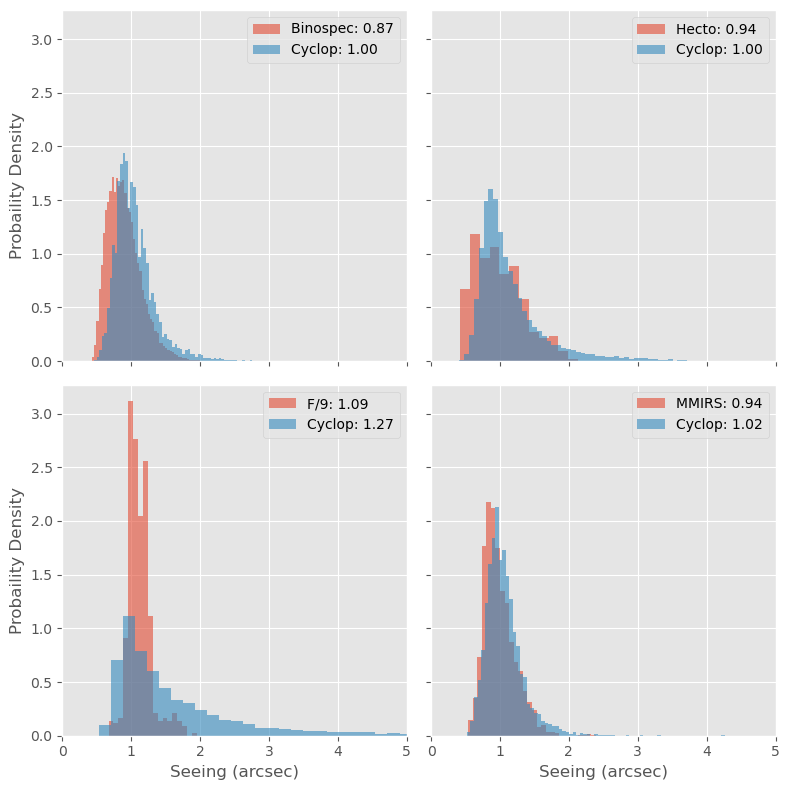

In [36]:
with plt.style.context('ggplot', after_reset=False):
    fig, ax = plt.subplots(2, 2, figsize=(8, 8), sharex=True, sharey=True)
    ax = ax.flat
    fig.subplots_adjust(hspace=0)

    bin_type = "scott"

    hist(bino['vlt_seeing'], bins=bin_type, ax=ax[0], histtype='stepfilled', alpha=0.6, density=True)
    hist(cyc_bino, bins=bin_type, ax=ax[0], histtype='stepfilled', alpha=0.6, density=True)
    ax[0].legend([f"Binospec: {np.median(bino['vlt_seeing']):.2f}", f"Cyclop: {np.median(cyc_bino):.2f}"])
    ax[0].set_ylabel("Probaility Density")
    ax[0].set_xlim(0, 5)

    hist(hecto['vlt_seeing'], bins=bin_type, ax=ax[1], histtype='stepfilled', alpha=0.6, density=True)
    hist(cyc_hecto, bins=bin_type, ax=ax[1], histtype='stepfilled', alpha=0.6, density=True)
    ax[1].legend([f"Hecto: {np.median(hecto['vlt_seeing']):.2f}", f"Cyclop: {np.median(cyc_hecto):.2f}"])
    ax[1].set_xlim(0, 5)

    hist(f9['vlt_seeing'], bins=bin_type, ax=ax[2], histtype='stepfilled', alpha=0.6, density=True)
    hist(cyc_f9, bins=bin_type, ax=ax[2], histtype='stepfilled', alpha=0.6, density=True)
    ax[2].legend([f"F/9: {np.median(f9['vlt_seeing']):.2f}", f"Cyclop: {np.median(cyc_f9):.2f}"])
    ax[2].set_xlim(0, 5)
    ax[2].set_xlabel("Seeing (arcsec)")
    ax[2].set_ylabel("Probaility Density")

    hist(mmirs['vlt_seeing'], bins=bin_type, ax=ax[3], histtype='stepfilled', alpha=0.6, density=True)
    hist(cyc_mmirs, bins=bin_type, ax=ax[3], histtype='stepfilled', alpha=0.6, density=True)
    ax[3].legend([f"MMIRS: {np.median(mmirs['vlt_seeing']):.2f}", f"Cyclop: {np.median(cyc_mmirs):.2f}"])
    ax[3].set_xlim(0, 5)
    ax[3].set_xlabel("Seeing (arcsec)")

    plt.tight_layout()
    plt.savefig(f"{YEAR}_cyclop_vs_inst.png")
    plt.show()

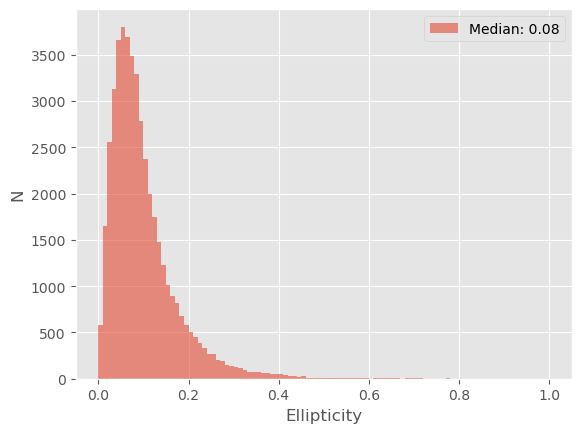

In [37]:
plt.hist(fixed['ellipticity'], bins=100, range=(0.0, 1.0), alpha=0.6, label=f"Median: {np.median(fixed['ellipticity']):.2f}")
plt.xlabel("Ellipticity")
plt.ylabel("N")
plt.legend()
plt.savefig(f"ellipticity_{YEAR}.png")
plt.show()


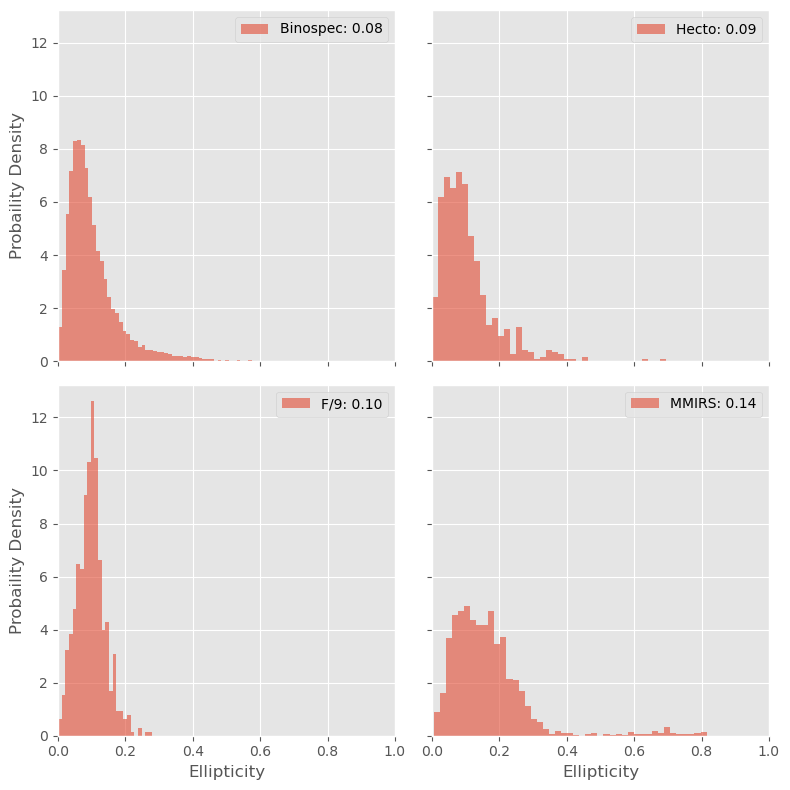

In [38]:
with plt.style.context('ggplot', after_reset=False):
    fig, ax = plt.subplots(2, 2, figsize=(8, 8), sharex=True, sharey=True)
    ax = ax.flat
    fig.subplots_adjust(hspace=0)

    bin_type = "knuth"

    hist(bino['ellipticity'], bins=bin_type, ax=ax[0], histtype='stepfilled', alpha=0.6, density=True)
    ax[0].legend([f"Binospec: {np.median(bino['ellipticity']):.2f}"])
    ax[0].set_ylabel("Probaility Density")
    ax[0].set_xlim(0, 1)

    hist(hecto['ellipticity'], bins=bin_type, ax=ax[1], histtype='stepfilled', alpha=0.6, density=True)
    ax[1].legend([f"Hecto: {np.median(hecto['ellipticity']):.2f}"])
    ax[1].set_xlim(0, 1)

    hist(f9['ellipticity'], bins=bin_type, ax=ax[2], histtype='stepfilled', alpha=0.6, density=True)
    ax[2].legend([f"F/9: {np.median(f9['ellipticity']):.2f}"])
    ax[2].set_xlim(0, 1)
    ax[2].set_xlabel("Ellipticity")
    ax[2].set_ylabel("Probaility Density")

    hist(mmirs['ellipticity'], bins=bin_type, ax=ax[3], histtype='stepfilled', alpha=0.6, density=True)
    ax[3].legend([f"MMIRS: {np.median(mmirs['ellipticity']):.2f}"])
    ax[3].set_xlim(0, 1)
    ax[3].set_xlabel("Ellipticity")

    plt.tight_layout()
    plt.savefig(f"{YEAR}_ellip_vs_inst.png")
    plt.show()